# Qualità dell'aria

Correlazione tra inquinanti atmosferici e casi COVID-19 in Lombardia nel 2020.

> Max Pierini, Sandra Mazzoli, Marco Filippi, Alfredo Benni

**NB: questo articolo è un progetto aperto e ancora in fase di revisione e completamento. Per proposte di collaborazione, scrivere a info@epidata.it**

***

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import Markdown, Image

# Introduzione

Si presenta uno studio retrospettivo sulla correlazione tra le medie giornaliere degli inquinanti atmosferici

- Monossido di Carbonio (**CO**)
- Ossidi di Azoto (**NOx**)
- Biossido di Azoto (**NO2**)
- Ozono (**O3**)
- Particolato atmosferico di diametro inferiore a 2.5 µm (**PM25**)
- Particolato atmosferico di diametro inferiore a 10 µm (**PM10**)

e le incidenze giornaliere di casi di COVID-19 nelle province Lombarde di

- Bergamo
- Brescia
- Como
- Cremona
- Lecco
- Lodi
- Monza e della Brianza
- Milano
- Mantova
- Pavia
- Sondrio
- Varese

nel 2020.

Per i casi di COVID-19 giornalieri provinciali in Lombardia è stato utilizzato il dataset pubblico del [Dipartimento di Protezione Civile](https://github.com/pcm-dpc/COVID-19) (**DPC**). Per la stima dell'incidenza il dataset di [ISTAT](http://dati.istat.it/#) sulla popolazione residente in Italia al 1 Gennaio 2021.

Per i valori giornalieri degli inquinanti atmosferici è stato usato il dataset degli [OpenData della Regione Lombardia](https://www.dati.lombardia.it/) (**ORL**).

# Dati

## COVID-19

La data dei casi di COVID-19 del dataset DPC è relativa al giorno della comunicazione della diagnosi.

È necessario pertanto stimare il giorno dell'infezione per poter correlare i valori degli inquinanti.

Dal confronto con i casi diagnosticati di COVID-19 del dataset nazionale del DPC e i casi sintomatici del [dataset dell'Istituto Superiore di Sanità](https://www.epicentro.iss.it/coronavirus/sars-cov-2-sorveglianza-dati) (**ISS**) possiamo stimare l'intervallo tra inizio dei sintomi e comunicazione della diagnosi da test positivo (**onset-to-diagnosis-communication**).

Grazie allo studio di [Flaxman et al. 2020](https://arxiv.org/abs/2004.11342) conosciamo la distribuzione Gamma dell'intervallo tra infezione e inizio dei sintomi (**infection-to-onset**).

Da questi possiamo ottenere perciò una stima dell'intervallo tra infezione e comunicazione della diagnosi (**infection-to-diagnosis-communication**).

Per ciascuna provincia lombarda, dai nuovi casi giornalieri è stato stimato il trend tramite decomposizione stagionale su periodo di 7 giorni. Sulla base trend abbiamo ottenuto la stima dell'incidenza giornaliera su 100 000 abitanti. Il metodo utilizzato e i dati sono disponibili nel materiale supplementare all'indirizzo [GitHub](https://github.com/maxdevblock/covid-19-air-quality).

## Inquinanti atmosferici

Per ciascun inquinante convertito in µg/m3 in ciascuna stazione di controllo qualità dell'aria in Lombardia aggregato per mediana giornaliera, è stato stimato il trend tramite decomposizione stagionale su periodo di 28 giorni ed aggregato per mediana provinciale. Il metodo utilizzato e i dati sono disponibili nel materiale supplementare all'indirizzo [GitHub](https://github.com/maxdevblock/covid-19-air-quality).

# Modello

Data la nota correlazione degli inquinanti atmosferici (vedi Discussione), non possono essere considerati indipendenti tra loro, come risulta evidente anche in figura.

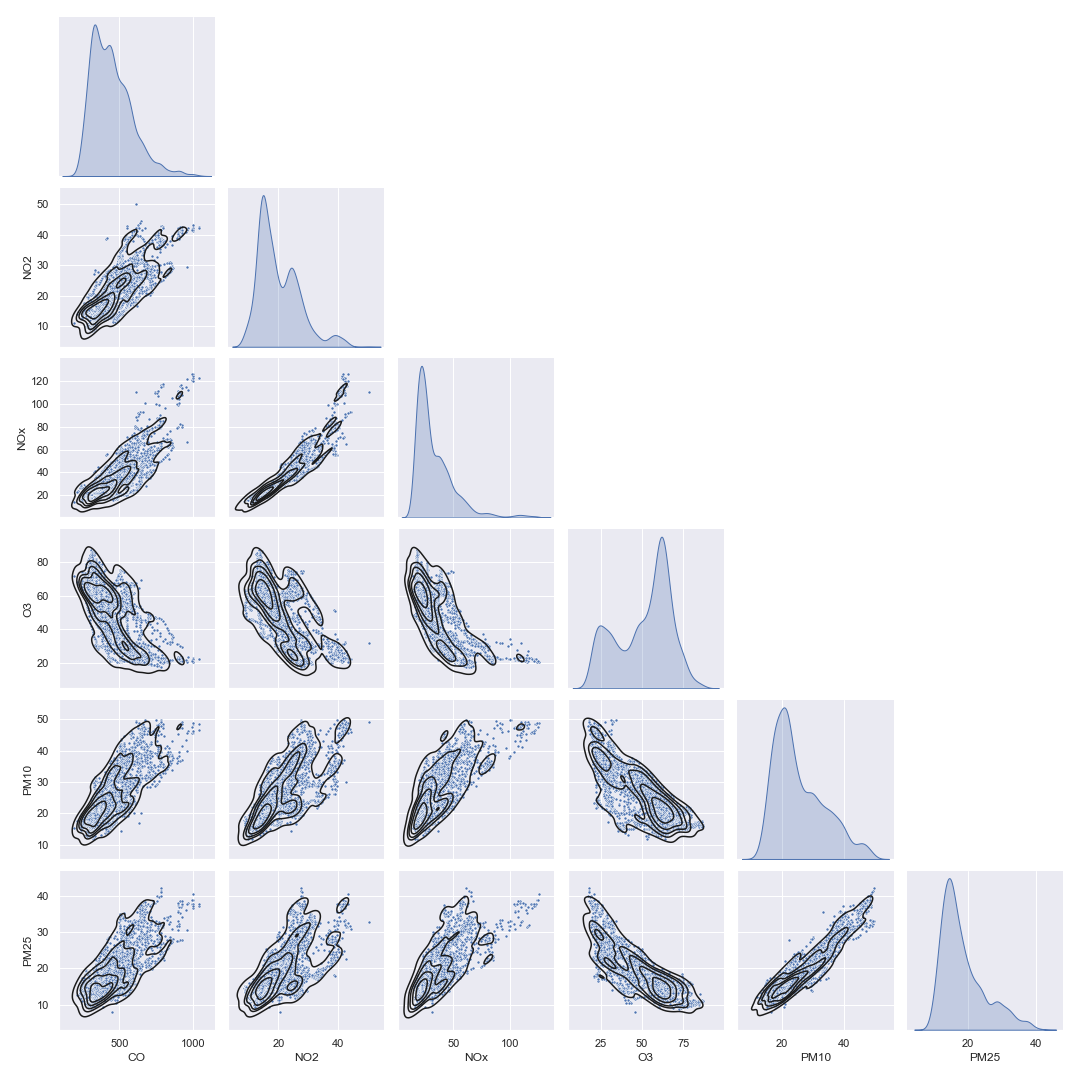

In [2]:
Image(filename='images/features_pairplot.png')

Pertanto singolarmente per ciascun inquinante $i$, il modello utilizzato è

$$
\log(y_t) = \sum_{p} \alpha_{i,p} + \alpha_{i,w} + \sum_{p} \alpha_{i,w,p} + \beta_{i,\tau} \log(x_{i,t-\tau})
$$

dove $y_t$ è l'incidenza giornaliera al tempo $t$, $x_{i,t-\tau}$ il valore dell'inquinante $i$ al tempo $t-\tau$ e $\tau$ è l'intervallo infection-to-communication, $\alpha_{i,p}$ l'intercetta della $p$-esima provincia e $\alpha_{i,w}$ l'intercetta di "prima ondata" (ovvero per dati antecedenti al 1 Luglio 2020).

Il modello assicura

- la variabilità interprovinciale tramite le intercette $\alpha_{i,p}$
- la differenza di tracciamento e contact-tracing tra prima e seconda ondata tramite l'intercetta $\alpha_{i,w}$
- l'interazione tra provincia e ondata tramite il coefficiente d'interazione $\alpha_{i,w,p}$
- la minimizzazione dell'eteroschedasticità grazie alla trasformazione logaritmica dei dati numerici

Per O3 sarebbe più corretto utilizzare un modello di regressione non lineare, ma abbiamo scelto di utilizzare il medesimo modello per poter più facilmente confrontare i risultati.

Per ciascun valore di $\tau$ otteniamo il coefficiente $\beta_{i,\tau}$ e l'errore standard $\sigma_{i,\tau}$ che abbiamo utiizzato per ricavare la distribuzione Gaussiana del coefficiente di correlazione

$$
\hat{\beta}_{i,\tau} \sim \mathcal{N}(\mu=\beta_{i,\tau} \;,\; \sigma=\sigma_{i,\tau})
$$

da cui sono stati ottenuti 10 000 campioni random.

Per ogni inquinante $i$, la distribuzione del coefficiente $\beta_i$ è stata stimata dalla concatenazione dei campioni dei parametri $\hat{\beta}_{i,\tau}$ normalizzati dalla moltiplicazione per la deviazione standard dei valori trasformati (logaritmo). Il metodo utilizzato e i dati sono disponibili nel materiale supplementare all'indirizzo [GitHub](https://github.com/maxdevblock/covid-19-air-quality).

Non ci aspettiamo dal modello valori del coefficiente di determinazione $R^2$ particolarmente elevati data la semplicità del modello, ma non eccessivamente inferiori a 0.5.

# Intervalli temporali

Per stimare la distribuzione dell'intervallo tra infezione e comunicazione della diagnosi, confrontiamo il dataset nazionale dei nuovi positivi di DPC e il dataset dei sintomatici di ISS.

Gli unici dati pubblici attualmente disponibili a livello provinciale sono quelli del DPC.

La data è relativa però alla data di comunicazione dell'evento e non alla data dell'evento stesso.

In particolare, per i nuovi casi, la data si riferisce alla comunicazione della diagnosi (test positivo)

Pertanto, utilizzando i dati ISS dei nuovi casi sintomatici, che invece si riferiscono alla data effettiva dell'evento ma disponibili solo a livello nazionale, possiamo stimare, l'intervallo onset-to-diagnosis-communication, ovvero dall'inizio dei sintomi alla comunicazione di diagnosi, scegliendo l'intervallo che minimizzi l'errore medio assoluto (**MAE**) tra la comunicazione dei dati (dataset DPC) e l'evento (dataset ISS).

Grazie al lavoro di [Flaxman et al. 2020](https://arxiv.org/abs/2004.11342), possiamo stimare l'intervallo infection-to-onset, ovvero dall'infezione all'inizio dei sintomi (periodo d'incubazione) e giungere così alla determinazione della distribuzione dell'intervallo infection-to-diagnosis-communication, ovvero dalla data dell'infezione alla data di comunicazione della diagnosi.

Si suppone che la distribuzione dell'intervallo a livello nazionale sia valido anche a livello provinciale.

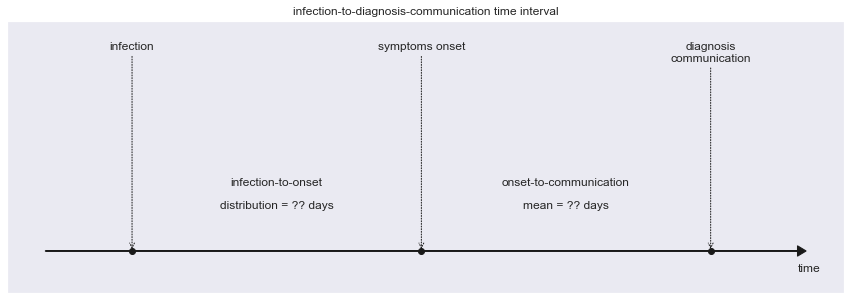

In [3]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.arrow(-3, 0, 26, 0, color='k', head_width=.05, head_length=.3)

for x, t in zip([0, 10, 20],
             [
                 'infection',
                 'symptoms onset',
                 'diagnosis\ncommunication',

             ]):
    ax.scatter(x, 0, color='k')
    ax.annotate(
        t, xy=(x, 0),
        xytext=(x, 1),
        arrowprops=dict(color='k', arrowstyle='->', ls=':'),
        ha='center', va='top'
    )
    
for x, t in zip([5, 15],
                   [
                       'infection-to-onset\n\ndistribution = ?? days',
                       'onset-to-communication\n\nmean = ?? days'
                   ]
                  ):
    ax.text(x, .2, t, ha='center')
    
ax.text(
    23, -.1,
    "time",
)
ax.set(
    yticks=[], xticks=[],
    ylim=(-.2, 1.1),
    title='infection-to-diagnosis-communication time interval'
)
plt.show()

In [4]:
dpc = pd.read_csv(
    'nation.csv',
    parse_dates=['date'], index_col='date'
)

In [5]:
sint = pd.read_csv('ISS-sint.csv', parse_dates=['date'], index_col='date')
decs = pd.read_csv('ISS-decs.csv', parse_dates=['date'], index_col='date')

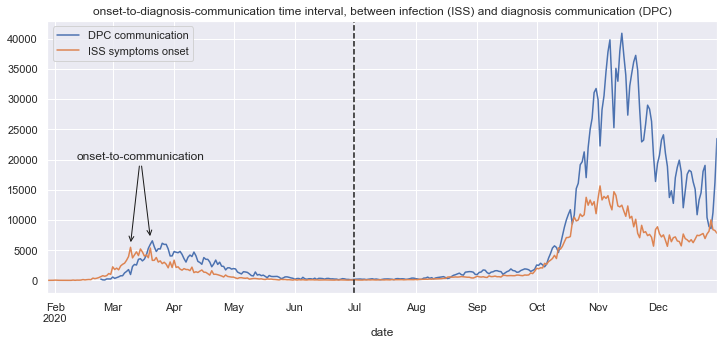

In [6]:
ax = dpc[dpc.index<'2021-01-01'].plot(
    figsize=(12, 5),
    y='new_cases',
    label='DPC communication',
    title='onset-to-diagnosis-communication time interval, between infection (ISS) and diagnosis communication (DPC)'
)
sint[sint.index<'2021-01-01'].dropna().plot(ax=ax, y='new_onset_events', label='ISS symptoms onset')
ax.axvline('2020-07-01', ls='--', color='k')
ax.annotate(
    'onset-to-communication',
    xy=('2020-03-10', 6000),
    xytext=('2020-03-15', 20000),
    arrowprops=dict(color='k', arrowstyle='->'),
    ha='center'
)
ax.annotate(
    'onset-to-communication',
    xy=('2020-03-20', 7000),
    xytext=('2020-03-15', 20000),
    arrowprops=dict(color='k', arrowstyle='->'),
    ha='center',
    alpha=0
)
plt.show()

Data la notevole differenza tra i casi sintomatici (ISS) e i casi diagnosticati (DPC) della seconda ondata, abbiamo analizzato solamente i dati della prima ondata (anteriore al 1 Luglio 2020).

In [7]:
MAEs = {
    'shift': [],
    'MAE': [],
}

for shift in np.arange(30):
    _dpc = dpc.copy(deep=True)
    _dpc.index = _dpc.index - pd.Timedelta(days=shift)
    _x = _dpc[['new_cases']]  #.rolling(7, center=True).mean()
    _y = sint[sint.index<='2020-07-01'][['new_onset_events']]  #.rolling(7, center=True).mean()
    _df = _x.merge(
        _y,
        left_index=True, right_index=True
    ).dropna()
    mae = mean_absolute_error(_df.new_onset_events, _df.new_cases)
    MAEs['shift'].append(shift)
    MAEs['MAE'].append(mae)

MAEs_df = pd.DataFrame(MAEs)

In [8]:
min_MAE_OC = MAEs_df[
    (MAEs_df.MAE<600)
]['shift'].mean()

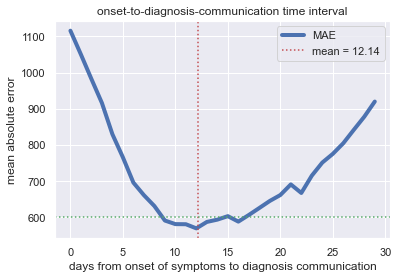

In [9]:
ax = MAEs_df.plot(x='shift', y='MAE', lw=4)
ax.axvline(min_MAE_OC, color='r', ls=':', label=f"mean = {min_MAE_OC:.2f}")
ax.axhline(600, color='g', ls=':')
ax.set(
    title='onset-to-diagnosis-communication time interval',
    ylabel='mean absolute error',
    xlabel='days from onset of symptoms to diagnosis communication'
)
ax.legend()
plt.show()

In [10]:
cov1 = 0.86

dt_incub_lo = 4.1
dt_incub_hi = 7.0
incub_mu = (dt_incub_lo + dt_incub_hi) / 2

# compute parameters for gamma distributions
incub_sd = incub_mu * cov1
incub_alpha = incub_mu**2 / incub_sd**2
incub_beta = incub_mu / incub_sd**2
incub_dist = sps.gamma(a=incub_alpha, scale=1/incub_beta)
incub_x = np.linspace(0, 30, 200)
incub_y = incub_dist.pdf(incub_x)

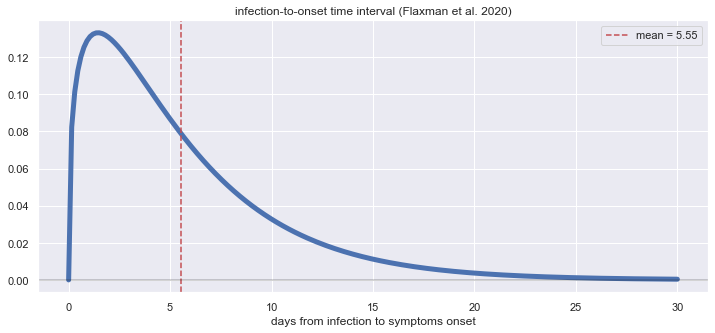

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(incub_x, incub_y, lw=5)
ax.axvline(incub_mu, color='r', ls='--', label=f"mean = {incub_mu}")
ax.axhline(0, color='k', alpha=.25)
ax.legend()
ax.set(
    title='infection-to-onset time interval (Flaxman et al. 2020)',
    xlabel='days from infection to symptoms onset'
)
plt.show()

In [12]:
IC_interval = incub_x + min_MAE_OC
IC_interval_mean = incub_mu + min_MAE_OC
IC_interval_min = IC_interval.min()
IC_interval_max = IC_interval.max()

Sommando la stima dell'intervallo onset-to-diagnosis-communication alla distribuzione dell'intervallo infection-to-onset, otteniamo dunque la stima della distribuzione dell'intervallo infection-to-diagnosis-communication.

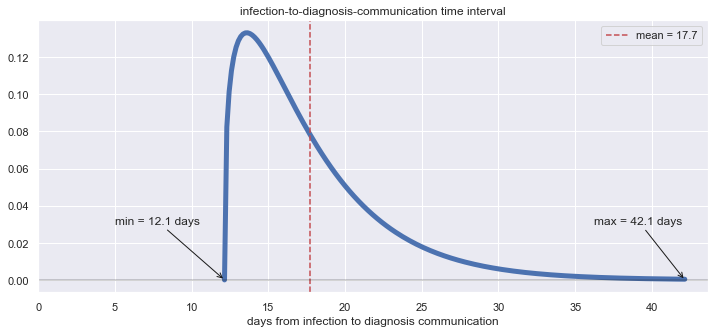

In [13]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(IC_interval, incub_y, lw=5)
ax.axvline(IC_interval_mean, color='r', ls='--', label=f"mean = {IC_interval_mean:.1f}")
ax.axhline(0, color='k', alpha=.25)
ax.annotate(
    f'min = {IC_interval_min:.1f} days',
    xy=(IC_interval_min, 0),
    xytext=(5, .03),
    arrowprops=dict(color='k', arrowstyle='->')
)
ax.annotate(
    f'max = {IC_interval_max:.1f} days',
    xy=(IC_interval_max, 0),
    xytext=(42, .03),
    arrowprops=dict(color='k', arrowstyle='->'),
    ha='right'
)
ax.legend()
ax.set(
    title='infection-to-diagnosis-communication time interval',
    xlabel='days from infection to diagnosis communication',
    xlim=(0, ax.get_xlim()[1])
)
plt.show()

In [14]:
Markdown(f"""
Pertanto è stata effettuata la correlazione tra i casi comunicati
del dataset provinciale DPC e i valori degli inquinanti da
{IC_interval_min:.0f} a {IC_interval_max:.0f} giorni prima,
ovvero nei probabili giorni dell'infezione.
""")


Pertanto è stata effettuata la correlazione tra i casi comunicati
del dataset provinciale DPC e i valori degli inquinanti da
12 a 42 giorni prima,
ovvero nei probabili giorni dell'infezione.


# Risultati

## EDA

Analisi esplorativa dei dati (EDA) preliminare: l'analisi visiva conferma una correlazione tra inquinanti e incidenze di COVID-19.

Per O3 la correlazione sembrerebbe essere meno lineare ma, come già detto, abbiamo deciso di utilizzare il modello lineare per poter più facilmente confrontare i risultati.

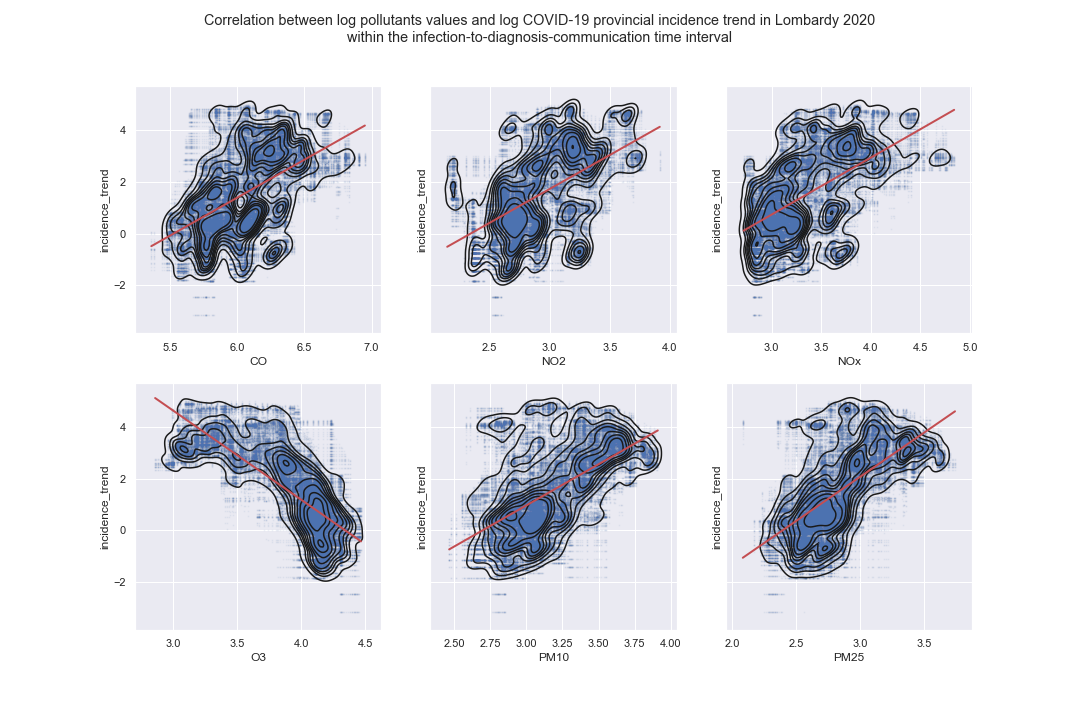

In [15]:
Image(filename='images/correlation_EDA.png')

## Coefficiente di determinazione

Come atteso, i coeffcienti di determinazione $R^2$ per ciascun inquinante e ciascun giorno dell'intervallo infection-to-diagnosis-communication sono intorno a 0.5.

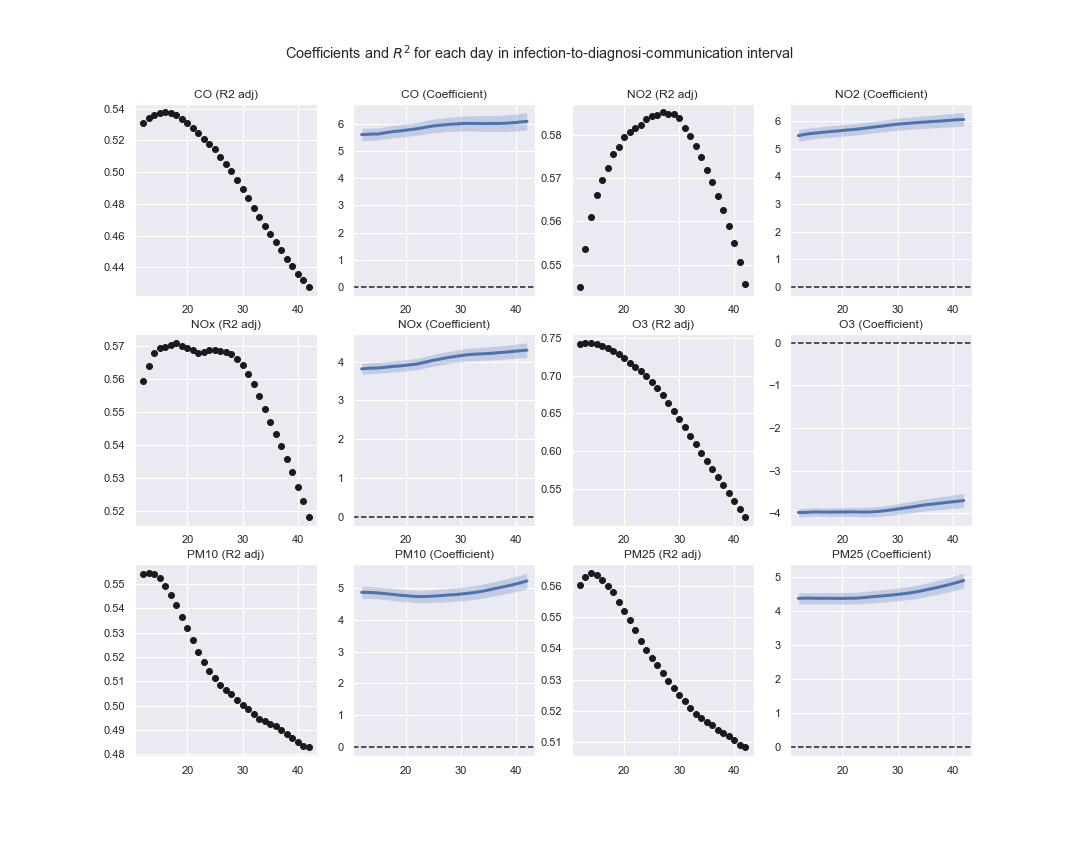

In [16]:
Image(filename='images/coefficients_R2.png')

## Distribuzioni dei coefficienti

Distribuzioni gaussiane dei coefficienti di correlazione per ciascun giorno nell'intervallo infection-to-diagnosis-communication.

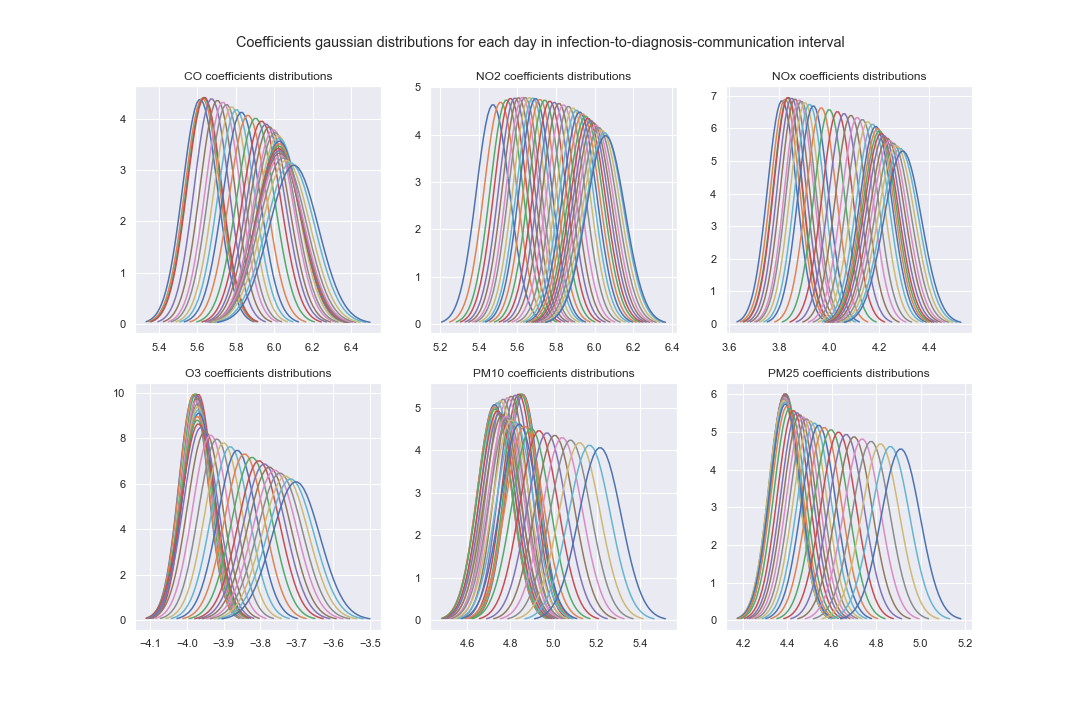

In [17]:
Image(filename='images/distributions.png')

## KDE dei coefficienti

Stima della distribuzione (KDE, kernel density estimate) dei coefficienti di correlazione nell'intervallo infection-to-diagnosis-communication.

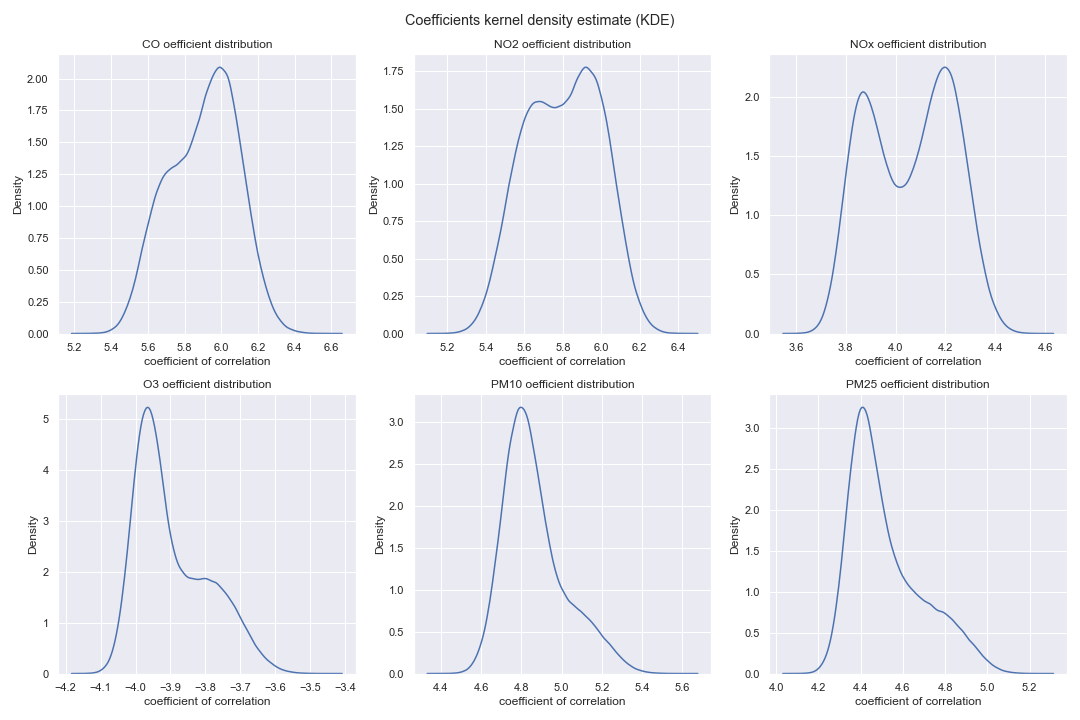

In [18]:
Image(filename='images/coefficients_distribution.png')

## Reali e previsti

Verifica dei valori reali del logaritmo dell'incidenza provinciale osservata (truths) e predetti dal modello di correlazione (predictions).

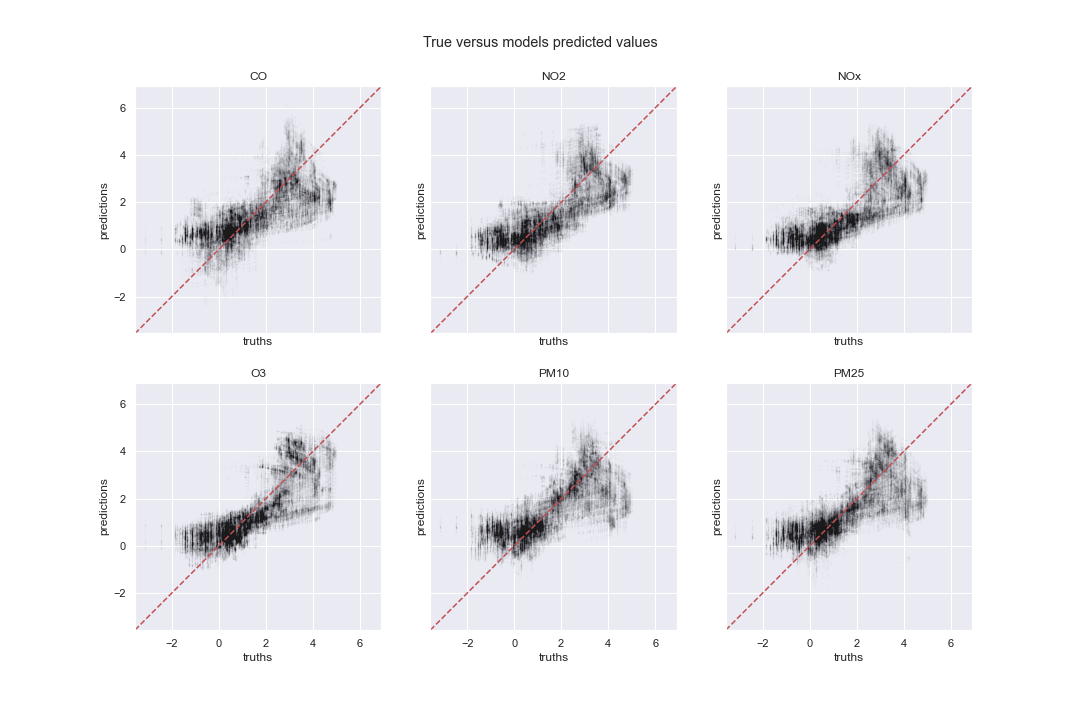

In [19]:
Image(filename='images/truths_predicted.png')

## Coefficienti di correlazione

Confronto dei coefficienti di correlazione dei modelli, non normalizzati.

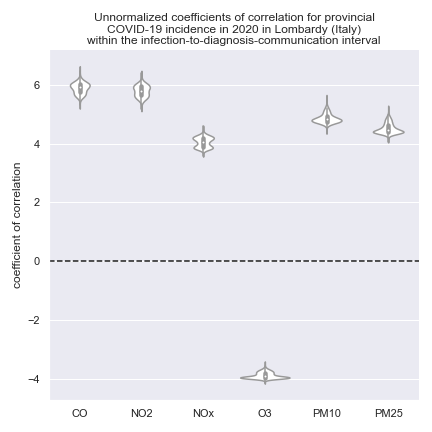

In [20]:
Image(filename='images/coefficients_unnormalized.png')

I coefficienti di correlazione rappresentano la variazione nel logaritmo dell'incidenza giornaliera provinciale di casi comunicati di COVID-19 in seguito alla variazione di una unità logaritmica del valore dell'inquinante tra 12 e 42 giorni prima (intervallo infection-to-diagnosis-communication) a parità di intercetta provinciale e ondata (prima o seconda).

I $p$-values dei coefficienti di correlazione per ciascun inquinante e ciascun giorno nell'intervallo infection-to-diagnosis-communication sono nettamente inferiori al livello di significatività 0.01

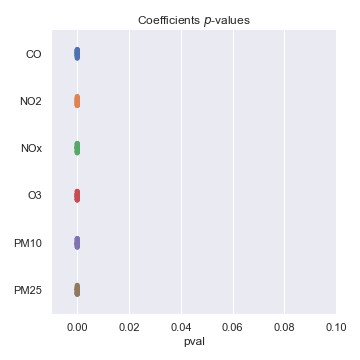

In [21]:
Image(filename='images/coefficients_pvalues.png')

## Deviazione standard delle variabili indipendenti

Deviazione standard del logaritmo delle variabili indipendenti (valori degli inquinanti).

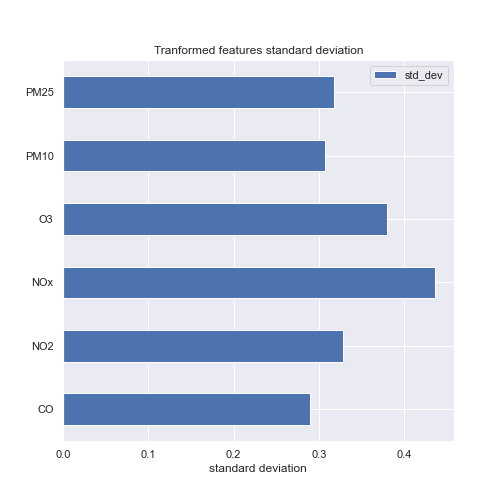

In [22]:
Image(filename='images/features_standard_deviation.png')

## Coefficienti normalizzati

Confronto tra i coefficienti di correlazione normalizzati.

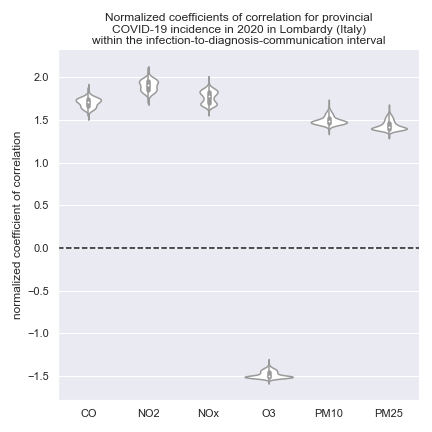

In [23]:
Image(filename='images/coefficients_normalized.png')

I coefficienti mostrano una correlazione positiva per CO, NO2, NOx, PM10, PM25 e una correlazione negativa per O3.

# Discussione

## CO

https://it.wikipedia.org/wiki/Monossido_di_carbonio

Il monossido di carbonio (CO) è un gas prodotto da reazioni di combustione incompleta, naturali (come incendi) o artificiali (motori a scoppio, stufe a gas). Ha un ruolo fondamentale nella formazione dell'ozono a livello del suolo.

Il CO è un'emotossina ed è pertanto altamente tossico per tutte le specie animali che usano emoglobina per trasportare ossigeno nel sangue.

## NO2

https://it.wikipedia.org/wiki/Diossido_di_azoto

Il biossido di azoto (NO2) è un gas prodotto dal nitrato di piombo o dalla reazione tra il monossido di azoto e l'ossigeno atmosferico. 

È un forte irritante delle vie polmonari; già a moderate concentrazioni nell'aria provoca tosse acuta, dolori al torace, convulsioni e insufficienza circolatoria. Può inoltre provocare danni irreversibili ai polmoni che possono manifestarsi anche molti mesi dopo l'attacco.

## NOx

https://it.wikipedia.org/wiki/NOx

La sigla NOx indica in modo generico gli ossidi di azoto ovvero

- il monossido di azoto (NO)
- il diossido di azoto o ipoazotide (NO2, anche come dimero N2O4)
- l'ossido di diazoto o protossido di azoto (N2O)
- il triossido di diazoto o anidride nitrosa (N2O3)
- il pentossido di diazoto o anidride nitrica (N2O5)

Gli NOx sono prodotti principalmente durante la combustione in presenza di aria (camini, motori a combustione, centrali termoelettriche) e in natura soprattutto dai fulmini ed eruzioni vulcaniche.

Sono sostanze inquinanti dell'atmosfera e aggravano le condizioni dei malati di asma, bambini e chi soffre di malattie respiratorie croniche o di malattie cardiache, in ogni caso superata la soglia di 10 ppm (da considerare essere una concentrazione migliaia di volte maggiore anche di ambienti urbani in cui difficilmente si superano i 0.05 ppm) insorgono problemi nella respirazione polmonare ed edemi polmonari, mentre già con 15 ppm si ha irritazione delle mucose e degli occhi.

Tra gli effetti a lungo termine si possono annoverare le alterazioni polmonari a livello tissutale e cellulare, aumento della suscettibilità alle infezioni polmonari sia di tipo batteriche che virali.

Alcuni di essi in presenza di radiazione solare possono reagire con l'ossigeno formando ozono e altri composti del cosiddetto smog fotochimico. Il triossido ed il pentossido di diazoto sono solubili in acqua e con l'umidità atmosferica possono formare acido nitroso e acido nitrico, entrambi presenti nelle cosiddette "piogge acide". Si possono anche combinare con ammoniaca formando sali di ammonio, responsabili di circa il 50% del particolato PM10 (vedi [legambiente 2020](https://alessandria.today/2020/02/18/legambiente-denuncia-lo-spargimento-di-liquami-selvaggi/)).

## O3

https://it.wikipedia.org/wiki/Ozono

È un gas instabile con un tempo di dimezzamento di tre giorni. Si forma da molecole di ossigeno (O2) in prossimità di scariche elettriche, scintille, fulmini ma anche da NOx e CO in presenza di radiazione solare. È un energico ossidante e per gli esseri viventi è altamente velenoso per gli occhi e le vie respiratorie.

Grazie alle proprietà ossidanti è però utilizzato per disinfezione e sanificazione di ambienti.
Essendo un potente ossidante, ha attività antibatterica ed è in grado di potenziare le difese organiche aspecifiche della pelle, inoltre è in grado di inibire la crescita e la proliferazione dei dermatofiti in corso di dermatite micotica. In medicina veterinaria viene utilizzato in dermatologia come terapia delle piodermiti superficiali e profonde; nelle lesioni di origine funginea, traumatica e immunologica, e anche nei casi di ferite caratterizzate da prurito e infiammazione. L'ozono trova ora impiego anche come terapia delle otiti di origine batterica e funginea, dove svolge attività antalgica e antiinfiammatoria. In ortopedia e chirurgia viene utilizzato per indurre una rapida cicatrizzazione in caso di ferite chirurgiche, fistole, suture e fissatori esterni.

Recentemente è stata dimostrata inattivazione di SARS-CoV-2 per esposizione a gas ozono.

## PM10 e PM25

https://it.wikipedia.org/wiki/Particolato

Il particolato atmosferico è un'insieme delle sostanze solide o liquide sospese in aria (con la quale formano una miscela detta "aerosol atmosferico") che hanno dimensioni che variano da pochi nanometri a 100 µm, più frequenti nelle aree urbane. Esempi di sostanze presenti nel particolato sono fibre naturali e artificiali, pollini, spore, particelle carboniose, metalli, silice e inquinanti liquidi.

L'origine di tali sostanze può essere naturale o associata all'attività umana. Il particolato è pericoloso per la salute umana e di altri esseri viventi. È stato definito come la forma più pericolosa di inquinamento atmosferico, a causa della sua capacità di penetrare nei polmoni e nel sangue, causando quindi attacchi cardiaci, malattie respiratorie, e morte prematura.

In particolare, si distingue in:

- PM10: particolato formato da particelle con dimensioni minori di 10 µm, denominato anche "frazione toracica" ovvero di particelle che sono in grado di raggiungere la trachea e i bronchi;
- PM25: particolato fine con diametro inferiore a 2.5 µm, denominato anche "frazione respirabile" per indicare la classe di particelle più piccole che è in grado di raggiungere gli alveoli e attraverso questi trasmettersi nel sangue

Le particelle più piccole sono costituite generalmente da vapori metallici, organici e frazione carboniosa, mentre le particelle più grossolane sono costituite generalmente da cristalli presenti naturalmente nella crosta terrestre e polveri provenienti dall'inquinamento veicolare e delle industrie.

Le principali fonti di particolato sono:

- Sorgenti legate all'attività umana: processi di combustione (tra cui quelli che avvengono nei motori a scoppio, negli impianti di riscaldamento, in molte attività industriali, negli inceneritori e nelle centrali termoelettriche), usura di pneumatici, freni ed asfalto.
- Sorgenti naturali: l'erosione del suolo, gli incendi boschivi, le eruzioni vulcaniche, la dispersione di pollini, il sale marino.

Fra i fattori naturali vi sono ad esempio:

- polvere, terra, sale marino alzati dal vento (il cosiddetto "aerosol marino");
- incendi;
- microrganismi;
- pollini e spore;
- erosione di rocce;
- eruzioni vulcaniche.

Fra i fattori antropici all'origine di gran parte degli inquinanti atmosferici vi sono:

- emissioni dei motori a combustione interna (autocarri, automobili, aeroplani, navi);
- emissioni del riscaldamento domestico (in particolare a gasolio, carbone e legna);
- usura dei freni e relative pastiglie di tutti i mezzi di trasporto;
- usura degli pneumatici dei mezzi circolanti su strada;
- usura del manto stradale;
- emissioni dell'industria in generale, dei cementifici, dei cantieri;
- emissioni da attività agricole;
- emissioni degli inceneritori e delle centrali termoelettriche (in particolare a carbone e a gasolio);
- fumo di tabacco.

Secondo i dati dell'APAT (Agenzia per la protezione dell'ambiente) (oggi ARPA regionali) riferiti al 2003, la produzione di PM10 in Italia deriverebbe: per il 49% dai trasporti; per il 27% dall'industria; per l'11% dal settore residenziale e terziario; per il 9% dal settore agricoltura e foreste; per il 4% dalla produzione di energia. Secondo uno studio del CSST su incarico dell'Automobile Club Italia, sul totale delle emissioni di PM10 in Italia il 29% deriverebbe dagli autoveicoli a gasolio, e in particolare l'8% dalle automobili in generale e l'1-2% dalle auto Euro3 ed Euro4.

Anche gli spandimenti di liquami zootecnici contribuiscono alla formazione di particolato atmosferico: le deiezioni zootecniche sono all'origine delle emissioni di ammoniaca, gas che si combina con gli NOx per formare sali d’ammonio, che compongono fino al 50% del particolato sottile, in particolare PM10 (vedi [legambiente 2020](https://alessandria.today/2020/02/18/legambiente-denuncia-lo-spargimento-di-liquami-selvaggi/)).

Legambiente osserva che nelle 4 regioni della pianura Padano-Veneta si concentra oltre l'85% di tutti i suini allevati in Italia, e oltre i 2/3 di tutti i bovini nazionali. Una densità di animali allevati che rappresenta, in termini di massa biologica, l’equivalente in peso di 50 milioni di esseri umani, ovvero oltre il doppio della popolazione residente (vedi [legambiente 2020](https://alessandria.today/2020/02/18/legambiente-denuncia-lo-spargimento-di-liquami-selvaggi/)).

Tra i disturbi attribuiti al particolato fine e ultrafine (PM10 e soprattutto PM25) vi sono patologie acute e croniche a carico dell'apparato respiratorio (asma, bronchiti, enfisema, allergia, tumori) e cardio-circolatorio (aggravamento dei sintomi cardiaci nei soggetti predisposti).
